In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported and configuration set successfully.")

Libraries imported and configuration set successfully.


In [4]:
def load_data(filepath):
    try:
        print(f"Loading data from '{filepath}'...")
        # Read CSV
        df = pd.read_csv(filepath)
        print(f"Success! Loaded {len(df):,} records.")
        return df
    except FileNotFoundError:
        print("Error: File not found! Please check the file name.")
        return None

# Execute loading
file_path = 'telecom_data_large.csv'
df = load_data(file_path)

# Display first 5 rows interactively
df.head()

Loading data from 'telecom_data_large.csv'...
Success! Loaded 1,000,000 records.


,Date,Duration,Data_Usage,Call_Type
0,2025-12-22 00:07:45.814040,2952,127.01,International
1,2025-12-02 08:16:49.814040,2167,442.01,International
2,2025-12-20 08:41:08.814040,2330,210.90,Internal
3,2025-12-20 15:55:36.814040,1961,345.08,International
4,2025-12-08 04:34:31.814040,1020,248.98,International


In [5]:
def clean_data(df):
    if df is None:
        return None

    print("Starting data cleaning process...")
    initial_count = len(df)

    # Drop duplicates
    df = df.drop_duplicates()

    # Handle missing values in critical columns
    df = df.dropna(subset=['Date', 'Duration', 'Data_Usage'])

    # Filter valid logical data (Duration > 0 and Data_Usage >= 0)
    df = df[(df['Duration'] > 0) & (df['Data_Usage'] >= 0)]

    # Convert Date column to datetime objects
    df['Date'] = pd.to_datetime(df['Date'])

    final_count = len(df)
    removed_count = initial_count - final_count

    print(f"Cleaning complete. Removed {removed_count} invalid records.")
    print(f"Remaining records: {final_count:,}")
    return df

# Apply cleaning
df = clean_data(df)

Starting data cleaning process...
Cleaning complete. Removed 12 invalid records.
Remaining records: 999,988


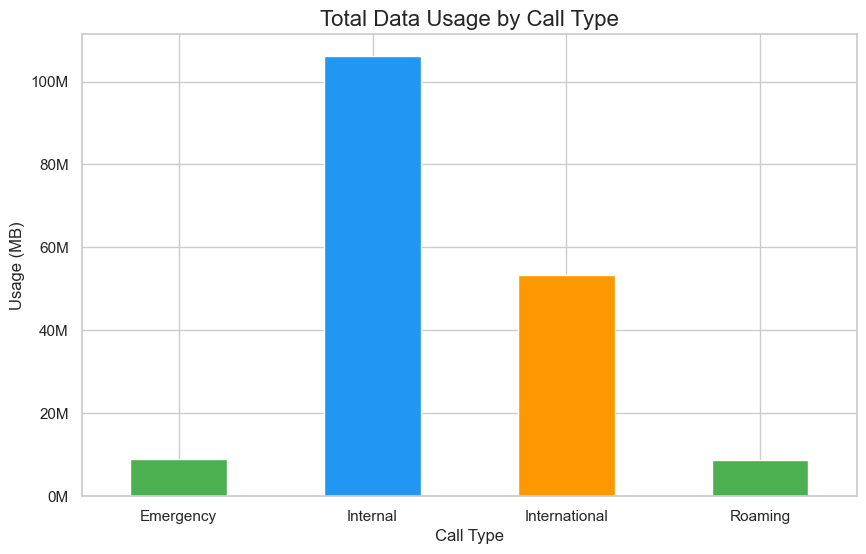

In [7]:
from matplotlib.ticker import FuncFormatter

# Group data by Call Type
call_type_usage = df.groupby('Call_Type')['Data_Usage'].sum()

# Plotting
plt.figure(figsize=(10, 6))
bars = call_type_usage.plot(kind='bar', color=['#4CAF50', '#2196F3', '#FF9800'])

plt.title('Total Data Usage by Call Type', fontsize=16)
plt.xlabel('Call Type', fontsize=12)
plt.ylabel('Usage (MB)', fontsize=12)
plt.xticks(rotation=0)

# CORRECT WAY: Use FuncFormatter to handle Millions (M) automatically
def millions(x, pos):
    return f'{x / 1000000:,.0f}M'

formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [12]:
def analyze_top_usage(df):
    # Calculate the 95th percentile (Top 5% threshold)
    threshold = df['Duration'].quantile(0.95)

    # Filter calls that are in the top 5%
    top_calls = df[df['Duration'] > threshold]

    print(f"Top 5% Threshold: {threshold:.2f} minutes")
    print(f"Number of High Duration Calls: {len(top_calls)}")
    print(f"Min Duration in this group: {top_calls['Duration'].min()}")
    print(f"Max Duration in this group: {top_calls['Duration'].max()}")

    return top_calls

high_usage_df = analyze_top_usage(df)

# Show top 5 longest calls sorted descending
print("\nTop 5 Longest Calls found:")
display(high_usage_df.sort_values('Duration', ascending=False).head())

Top 5% Threshold: 3420.00 minutes
Number of High Duration Calls: 49906
Min Duration in this group: 3421
Max Duration in this group: 3599

Top 5 Longest Calls found:


,Date,Duration,Data_Usage,Call_Type
380513,2025-12-20 08:39:06.814040,3599,378.32,Internal
349306,2025-12-11 11:05:33.814040,3599,145.36,Internal
537807,2025-12-18 23:15:34.814040,3599,0.00,Internal
214071,2025-12-22 21:13:24.814040,3599,11.73,Internal
989885,2025-12-28 11:10:49.814040,3599,0.00,Internal


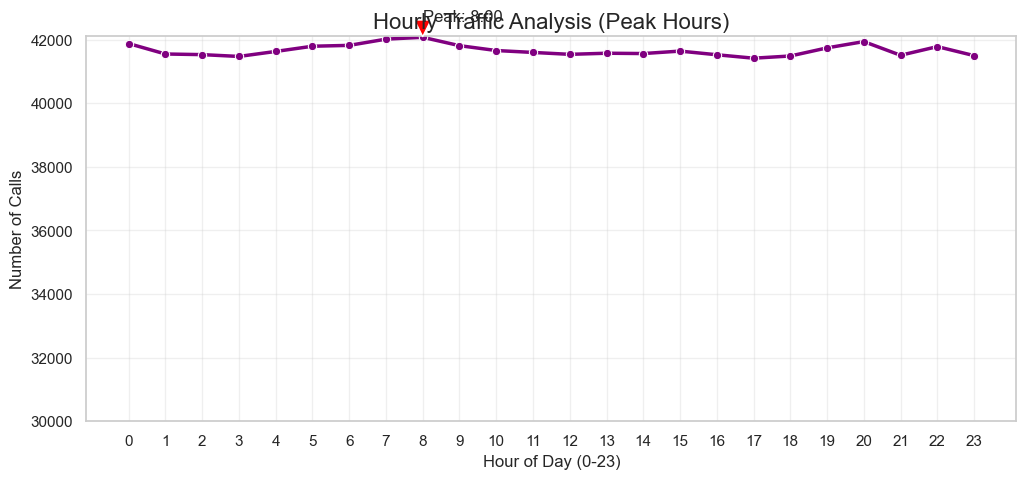

In [13]:
import seaborn as sns # Ensure seaborn is imported

# Extract Hour from Date
df['Hour'] = df['Date'].dt.hour

# Count calls per hour
hourly_traffic = df.groupby('Hour').size()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=hourly_traffic.index, y=hourly_traffic.values, marker='o', color='purple', linewidth=2.5)

plt.title('Hourly Traffic Analysis (Peak Hours)', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Calls', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# Highlight the Peak Hour
peak_hour = hourly_traffic.idxmax()
peak_value = hourly_traffic.max()

# Start Y-axis from 30,000 as requested previously for better visualization
plt.ylim(bottom=30000)

plt.annotate(f'Peak: {peak_hour}:00', xy=(peak_hour, peak_value), xytext=(peak_hour, peak_value+500),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

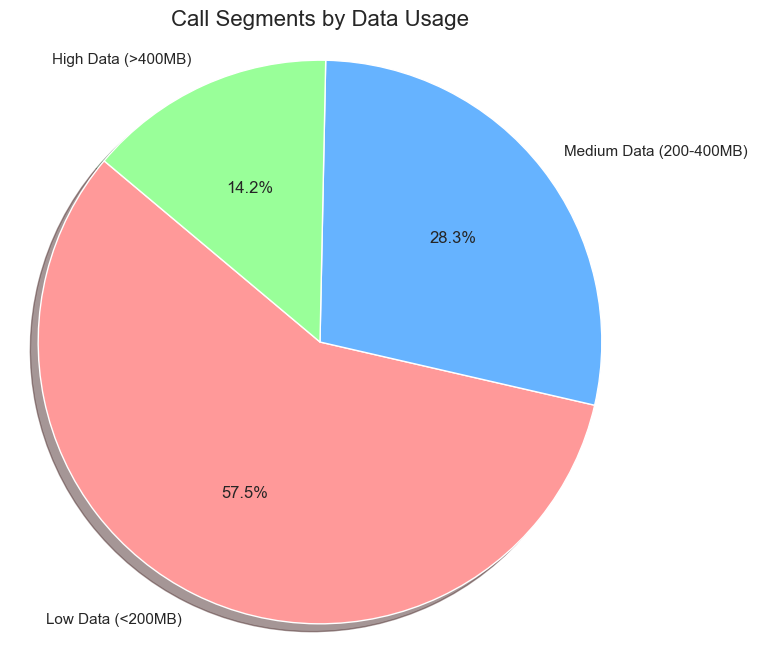

In [14]:
# Segment calls based on Data Usage
def segment_calls(row):
    if row['Data_Usage'] > 400:
        return 'High Data (>400MB)'
    elif row['Data_Usage'] > 200:
        return 'Medium Data (200-400MB)'
    else:
        return 'Low Data (<200MB)'

# Apply segmentation
df['Segment'] = df.apply(segment_calls, axis=1)

# Count segments
segment_counts = df['Segment'].value_counts()

# Plot Pie Chart
plt.figure(figsize=(8, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99'] # Red, Blue, Green pastel

plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=140, shadow=True)

plt.title('Call Segments by Data Usage', fontsize=16)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()